# Capstone Part 4.3 - Data Preprocessing / Random Forest Modelling 

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
combhotel_clean_df = pd.read_csv('combhotel_clean_df_v2.csv')

In [4]:
combhotel_clean_df.sample(3)

,hotel,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDate,IsCanceled,ADR_bin,got_assigned_room
17831,resort hotel,0,2016,April,15,4,1,0,2,0,...,Transient,65.0,0,1,Check-Out,2016-04-05,2016-04-04,False,51-100,True
59699,city hotel,35,2016,April,15,5,0,3,2,0,...,Transient,131.4,0,1,Check-Out,2016-04-08,2016-04-05,False,101-150,False
58124,city hotel,1,2016,March,10,5,0,1,2,0,...,Transient,98.0,0,0,Check-Out,2016-03-06,2016-03-05,False,51-100,True


In [5]:
combhotel_clean_df.columns

Index(['hotel', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDate', 'IsCanceled', 'ADR_bin', 'got_assigned_room'],
      dtype='object')

In [6]:
numerical_columns = ['LeadTime', 'StaysInWeekendNights','StaysInWeekNights','Adults','Children',
                   'Babies','PreviousCancellations','PreviousBookingsNotCanceled', 'BookingChanges',
                   'DaysInWaitingList','ADR','RequiredCarParkingSpaces','TotalOfSpecialRequests']

binary_columns = ['IsCanceled', 'IsRepeatedGuest', 'got_assigned_room']

categorical_columns = ['hotel','Meal', 'Country', 'MarketSegment', 'DistributionChannel',
                       'ReservedRoomType', 'AssignedRoomType','DepositType', 'Agent', 'Company',
                       'CustomerType','ReservationStatus', 'ADR_bin']

date_not_datetime_columns = ['ArrivalDateYear','ArrivalDateMonth','ArrivalDateWeekNumber','ArrivalDateDayOfMonth']

datetime_columns = ['ReservationStatusDate','ArrivalDate']

# Preprocessing

Selecting feature columns

In [7]:
feature_cols = ['hotel','LeadTime', 'ArrivalDateMonth','StaysInWeekendNights', 'StaysInWeekNights','MarketSegment',
                'DistributionChannel','IsRepeatedGuest','CustomerType','ADR_bin','got_assigned_room']

cat_cols = ['hotel', 'ArrivalDateMonth','MarketSegment','DistributionChannel','CustomerType', 'ADR_bin']

binary_cols =  ['IsRepeatedGuest', 'got_assigned_room']

num_cols = ['LeadTime','StaysInWeekendNights','StaysInWeekNights']

In [8]:
combhotel_preprocess_df = combhotel_clean_df[feature_cols]

**one-hot encode**

In [9]:
for col in cat_cols:
    combhotel_preprocess_df = pd.concat([combhotel_preprocess_df,pd.get_dummies(combhotel_preprocess_df[col], prefix= col, drop_first= True)],axis = 1)

Dropping original category columns

In [10]:
combhotel_preprocess_df = combhotel_preprocess_df.drop(cat_cols,axis = 1)

In [11]:
combhotel_preprocess_df.columns

Index(['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights',
       'IsRepeatedGuest', 'got_assigned_room', 'hotel_resort hotel',
       'ArrivalDateMonth_August', 'ArrivalDateMonth_December',
       'ArrivalDateMonth_February', 'ArrivalDateMonth_January',
       'ArrivalDateMonth_July', 'ArrivalDateMonth_June',
       'ArrivalDateMonth_March', 'ArrivalDateMonth_May',
       'ArrivalDateMonth_November', 'ArrivalDateMonth_October',
       'ArrivalDateMonth_September', 'MarketSegment_Complementary',
       'MarketSegment_Corporate', 'MarketSegment_Direct',
       'MarketSegment_Groups', 'MarketSegment_Offline TA/TO',
       'MarketSegment_Online TA', 'DistributionChannel_Direct',
       'DistributionChannel_GDS', 'DistributionChannel_TA/TO',
       'CustomerType_Group', 'CustomerType_Transient',
       'CustomerType_Transient-Party', 'ADR_bin_101-150', 'ADR_bin_151-200',
       'ADR_bin_201-250', 'ADR_bin_251-300', 'ADR_bin_301-350',
       'ADR_bin_351-400', 'ADR_bin_401-450', 'ADR_b

## train_test_split


In [12]:
X = combhotel_preprocess_df
y = combhotel_clean_df['IsCanceled']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

## testing best max_depth to use to get max precision

In [14]:
preci_list = []
rec_list =[]
for i in range (1,51):
    rf = RandomForestClassifier(
    n_estimators=200,          # number of trees
    max_depth=i,            # maximum depth of each tree
    min_samples_split=2,       # min samples to split a node
    min_samples_leaf=1,        # min samples in a leaf node
    max_features='sqrt',       # features to consider at each split
    class_weight='balanced',   # handle imbalanced classes
    random_state=42,
    n_jobs = -1)

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    preci = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test,y_pred)
    preci_list.append(preci)
    rec_list.append(rec)


In [15]:
preci_frame = pd.DataFrame({'maxdepth': range(1,51), 'precision': preci_list})
preci_frame.precision.sort_values(ascending=False)

41    0.516974
36    0.516377
43    0.516210
40    0.516129
45    0.515878
35    0.515671
39    0.515413
32    0.515297
38    0.515103
49    0.514978
34    0.514962
44    0.514944
47    0.514847
30    0.514800
42    0.514565
33    0.514462
48    0.513940
46    0.513933
37    0.513593
31    0.513422
29    0.510865
27    0.509515
28    0.508826
26    0.506243
25    0.501105
24    0.495662
23    0.492141
22    0.490527
21    0.485856
20    0.483148
19    0.478999
18    0.476473
17    0.473863
16    0.471184
15    0.470375
14    0.467934
13    0.466529
12    0.466142
11    0.464696
10    0.464656
9     0.464272
8     0.463617
7     0.462739
6     0.461589
5     0.460144
4     0.459583
3     0.459115
2     0.455397
1     0.444030
0     0.442619
Name: precision, dtype: float64

In [16]:
recall_frame = pd.DataFrame({'maxdepth': range(1,51), 'recall': rec_list})
recall_frame.recall.sort_values(ascending=False)

15    0.757974
17    0.757765
16    0.756723
13    0.755472
14    0.754430
18    0.753596
12    0.753388
11    0.750469
10    0.748176
0     0.746925
19    0.746508
9     0.746300
1     0.745049
8     0.743798
7     0.741714
6     0.737753
5     0.735251
20    0.732124
4     0.731290
2     0.730040
3     0.729206
21    0.712529
22    0.690848
23    0.672295
24    0.643110
25    0.614342
26    0.591620
27    0.569314
28    0.552846
29    0.529289
30    0.518449
31    0.506358
32    0.491557
33    0.485720
34    0.480717
35    0.476756
36    0.476548
39    0.474046
40    0.473629
41    0.473004
38    0.472795
37    0.472587
42    0.471336
43    0.471336
45    0.470711
44    0.470502
47    0.469877
49    0.469460
46    0.469043
48    0.468835
Name: recall, dtype: float64

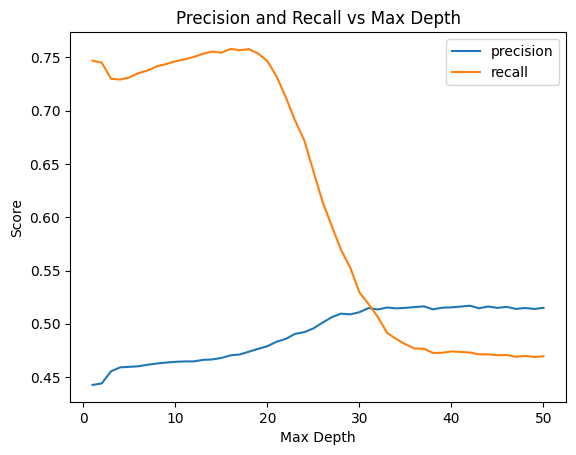

In [17]:
# create line plot
sns.lineplot(data=preci_frame, x='maxdepth', y='precision',label= 'precision')
sns.lineplot(data=recall_frame,x= 'maxdepth', y = 'recall', label = 'recall')
plt.title("Precision and Recall vs Max Depth")
plt.xlabel("Max Depth")
plt.legend() 
plt.ylabel("Score")
plt.show()

## Training a model using Random Forest Model

In [18]:
rf = RandomForestClassifier(
    n_estimators=200,          # number of trees
    max_depth=22,            # maximum depth of each tree
    min_samples_split=2,       # min samples to split a node
    min_samples_leaf=1,        # min samples in a leaf node
    max_features='sqrt',       # features to consider at each split
    class_weight='balanced',   # handle imbalanced classes
    random_state=42
)

## train model

In [19]:
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,22
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## test model

In [20]:
y_pred = rf.predict(X_test)

print("✅ F1 Score:", f1_score(y_test, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

✅ F1 Score: 0.5777552400270453

📊 Confusion Matrix:
 [[8974 3617]
 [1379 3418]]

📋 Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.71      0.78     12591
        True       0.49      0.71      0.58      4797

    accuracy                           0.71     17388
   macro avg       0.68      0.71      0.68     17388
weighted avg       0.76      0.71      0.73     17388



## Evaluation score 

In [21]:
print (f'accuracy: {accuracy_score(y_test,y_pred)}')
recall = metrics.recall_score(y_test, y_pred)
print (f'recall : {recall}')
precision = metrics.precision_score(y_test, y_pred)
print(f'precision: {precision}')
f1 = f1_score(y_test, y_pred)
print(f'f1: {f1}')

accuracy: 0.7126754083275822
recall : 0.7125286637481759
precision: 0.48585643212508883
f1: 0.5777552400270453


## test if overfit


In [22]:
y_pred_train = rf.predict(X_train)
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("\n📋 Classification Report:\n", classification_report(y_train, y_pred_train))



📊 Confusion Matrix:
 [[38681 11679]
 [ 1484 17705]]

📋 Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.77      0.85     50360
        True       0.60      0.92      0.73     19189

    accuracy                           0.81     69549
   macro avg       0.78      0.85      0.79     69549
weighted avg       0.86      0.81      0.82     69549



## Confusion matrix

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [24]:
cm = confusion_matrix(y_test, y_pred)

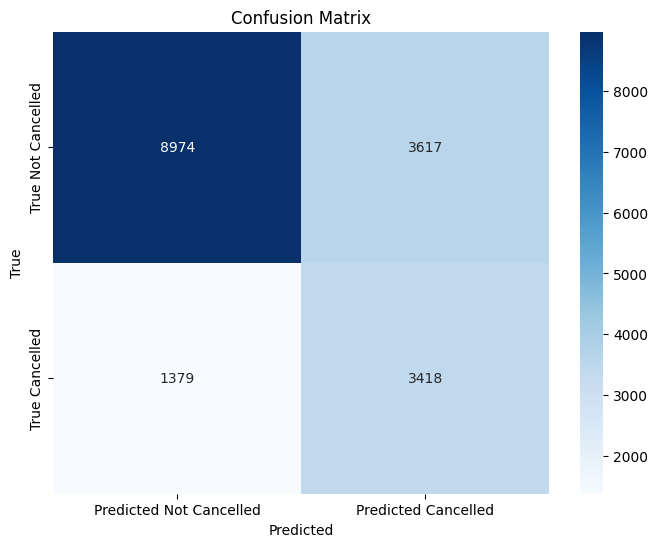

In [25]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not Cancelled', 'Predicted Cancelled'], yticklabels=['True Not Cancelled', 'True Cancelled'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()